In [1]:
#Basic Python Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import time
import warnings
warnings.filterwarnings("ignore") 
#Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#Scikit-Learn (Machine Learning Library for Python)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy 
from spacy import displacy

In [2]:
# Loading the csv files into dataframds
dev = pd.read_csv('../input/meld-dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv')
train = pd.read_csv('../input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv')
test = pd.read_csv('../input/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv')

In [3]:
#dev.head()
#train.head()
test.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"


In [4]:
# We will work with only two dataframes- one for training and other for testing
train_dev = pd.concat([train,dev])
train_dev

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
1104,1174,No.,Monica,sadness,negative,113,9,6,2,"00:19:28,792","00:19:29,876"
1105,1175,What? Oh my God! Im gonna miss you so much!,Rachel,sadness,negative,113,10,6,2,"00:19:33,213","00:19:35,965"
1106,1176,Im gonna miss you!,Monica,sadness,negative,113,11,6,2,"00:19:36,175","00:19:37,967"
1107,1177,I mean its the end of an era!,Rachel,sadness,negative,113,12,6,2,"00:19:39,094","00:19:40,928"


In [5]:
# Since we have concatenated the dataframes, resetting the indexes of the new one
train_dev.reset_index(inplace=True,drop=True)

In [6]:
# We will need only two columns for our sentiment analysis
sent = train_dev[['Utterance','Sentiment']]

In [7]:
# For our ML model to understand we will map the sentiments to numbers
def custom_encoder(df):
    df.replace(to_replace ="positive", value = 1, inplace=True)
    df.replace(to_replace ="neutral", value = 0, inplace=True)
    df.replace(to_replace ="negative", value = -1, inplace=True)

In [8]:
#Calling the funtion to encode the sentiments column
custom_encoder(sent['Sentiment'])

In [9]:
#Creating an object of WordNetLemmatizer
lm = WordNetLemmatizer()

In [10]:
# Function to preprocess text column to remove any characters other than alphabets, lemmatize the text, convert to lowercase
def data_preprocessing(text_col):
    corpus = []
    for row in text_col:
        new_row = row[0].capitalize() + row[1:].lower()
        new_row = re.sub('[^a-zA-Z]',' ',str(new_row)).split()
        new_row = [lm.lemmatize(word) for word in new_row if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_row))
    return corpus

In [11]:
transformed = data_preprocessing(sent['Utterance'])

In [12]:
# In the above data preprocessing step there were some empty strings. 
#Creating a dataframe to deal and remove those empty strings
tr_df = pd.DataFrame(zip(transformed,sent['Sentiment']), columns= ['Utterance','Sentiment'])

In [13]:
tr_df.head()

,Utterance,Sentiment
0,Also point person company transition kl gr system,0
1,You must hand full,0
2,That,0
3,So let talk little bit duty,0
4,My duty right,1


In [14]:
#Function to get the indices of the empty strings
def get_idx(df):   
    indexes = []
    for i,dialogue in enumerate(df):
        if len(dialogue) == 0:
            empty = df.index
            #print(empty)
            indexes.append(i)
    return indexes

In [15]:
empty_idx = get_idx(tr_df['Utterance'])

In [16]:
#Dropping the empty strings
clean_df = tr_df.drop(empty_idx)
clean_df.reset_index()

,index,Utterance,Sentiment
0,0,Also point person company transition kl gr system,0
1,1,You must hand full,0
2,2,That,0
3,3,So let talk little bit duty,0
4,4,My duty right,1
...,...,...,...
11082,11093,No,-1
11083,11094,What oh god gonna miss much,-1
11084,11095,I gonna miss,-1
11085,11096,I mean end era,-1


In [17]:
text = clean_df['Utterance'].to_list()

In [18]:
#text

# 1. NER Using NLTK 

In [19]:
words= []
for line in text:
    words.append(nltk.word_tokenize(line))

In [20]:
#words

In [21]:
#Converting the words which is list of list to a flat list of words
flat_word = [item for sublist in words for item in sublist]


In [22]:
#flat_word

In [23]:
#Part of speech tagging
pos_tags = nltk.pos_tag(flat_word)
#pos_tags


### Checking only whether it is Named Entity of not

In [24]:
chunks = nltk.ne_chunk(pos_tags, binary=False) #either NE or not NE
for chunk in chunks[:20]:
    print(chunk)

('Also', 'RB')
('point', 'NN')
('person', 'NN')
('company', 'NN')
('transition', 'NN')
('kl', 'NN')
('gr', 'NN')
('system', 'NN')
('You', 'PRP')
('must', 'MD')
('hand', 'NN')
('full', 'JJ')
('That', 'IN')
('So', 'NNP')
('let', 'VB')
('talk', 'VB')
('little', 'JJ')
('bit', 'NN')
('duty', 'JJ')
('My', 'NNP')


In [25]:
#Fetching NE and their labels
entities =[]
labels =[]
for chunk in chunks:
    if hasattr(chunk,'label'):
        #print(chunk)
        entities.append(' '.join(c[0] for c in chunk))
        labels.append(chunk.label())
        
entities_labels = list(set(zip(entities, labels)))
entities_df = pd.DataFrame(entities_labels, columns=["Entities","Labels"])
entities_df.sample(50)

,Entities,Labels
765,Cut,PERSON
515,Yeah So,PERSON
585,Who Don,PERSON
303,Hey Hi Well,PERSON
571,Right Ooh,PERSON
432,Awesome Yeah My,PERSON
525,Thank Go Go,PERSON
340,Come Hurry Oh,ORGANIZATION
624,Sit Okay,PERSON
318,Basically,PERSON


# 2. NER Using Spacy

In [26]:
# Load SpaCy model
#nlp = spacy.load("en_core_web_sm")      # Small model
#nlp = spacy.load("en_core_web_md")      # Medium model
nlp = spacy.load("en_core_web_lg")      # Large model

In [27]:
#Fetching entities and their specific labels

entities = []
labels = []
position_start = []
position_end = []
for line in text:
    doc = nlp(line)

    for ent in doc.ents:
        entities.append(ent)
        labels.append(ent.label_)
    
ent_df = pd.DataFrame({'Entities':entities,'Labels':labels})

In [28]:
#pd.set_option("display.max_rows", 50)
ent_df.sample(50)

,Entities,Labels
2005,(Joey),PERSON
316,(casey),PERSON
86,(ross),PERSON
413,(tonight),TIME
1721,(bambi),PERSON
2166,"(No, three, night, row)",TIME
723,(chandler),PERSON
487,(american),NORP
1683,(casey),PERSON
1339,(larry),PERSON


<BarContainer object of 10 artists>

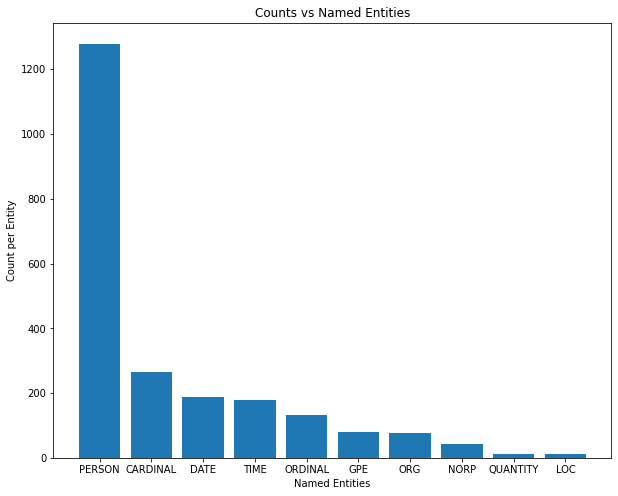

In [29]:
# Checking top 10 Entities 
plt.figure(figsize = (10,8))
plt.xlabel("Named Entities")
plt.ylabel("Count per Entity")
plt.title("Counts vs Named Entities")
plt.bar(ent_df['Labels'].value_counts().index[:10],ent_df['Labels'].value_counts().iloc[:10])